In [61]:
!pip install tensorflow transformers pandas scikit-learn nltk keras-tuner matplotlib seaborn wordcloud
!pip install wordcloud
!pip install tensorflow transformers pandas scikit-learn nltk keras-tuner

In [62]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import emoji
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Bidirectional, Dense, Dropout
from keras_tuner import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM

# Download stopwords
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [63]:
# Load the dataset
data_path = 'SemEval2017-task4-dev.subtask-A.english.INPUT.txt'
data = pd.read_table(data_path)
data.columns = ['id', 'Sentiment', 'Tweet', 'unknown']
data = data.drop('unknown', axis=1)

In [66]:
# Number of rows (lines)
num_rows = len(data)
print("Number of rows:", num_rows)

# File size (approximate)
file_size = data.memory_usage(deep=True).sum()
print("Approximate file size:", file_size)

Number of rows: 20631
Approximate file size: 5039882


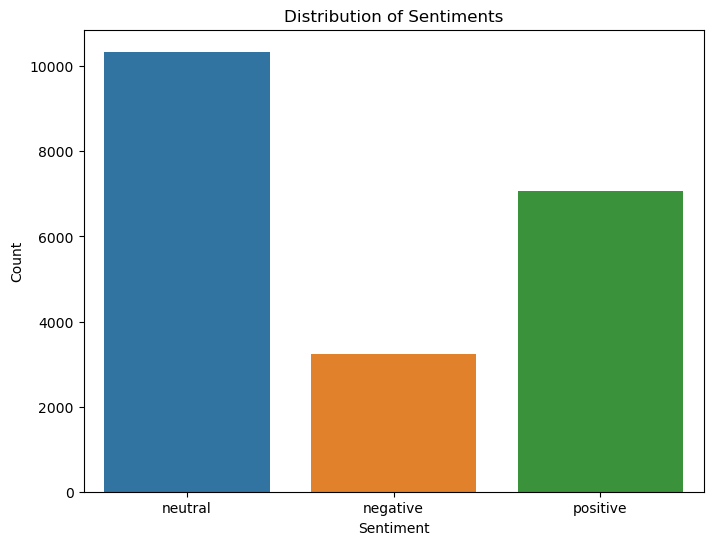

In [32]:
# EDA: Distribution of Sentiments
plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment', data=data)
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

C:\Users\PC\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


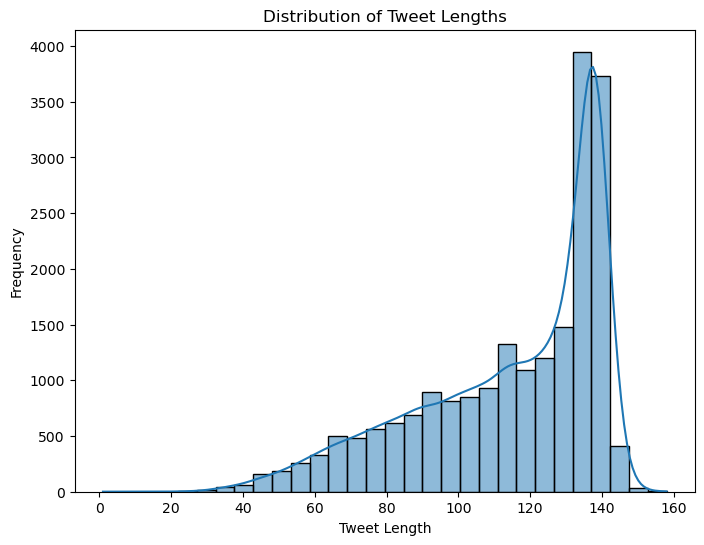

In [33]:
# EDA: Distribution of Tweet Lengths
data['tweet_length'] = data['Tweet'].apply(len)
plt.figure(figsize=(8, 6))
sns.histplot(data['tweet_length'], bins=30, kde=True)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()

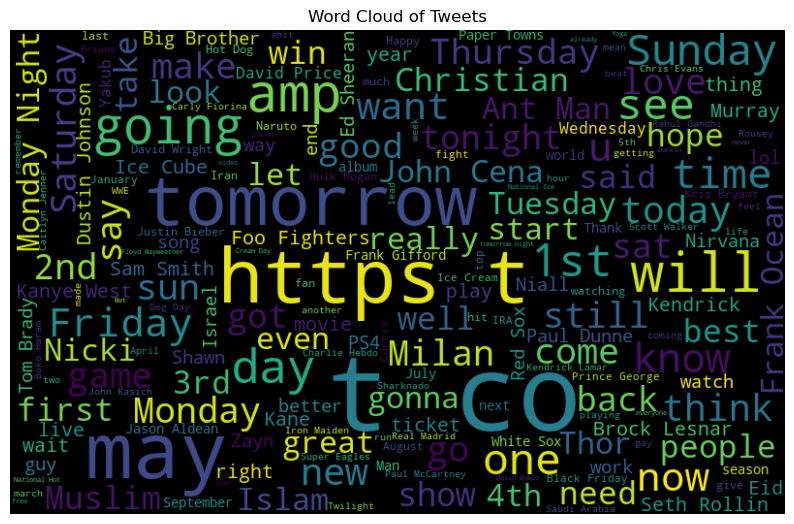

In [34]:
# EDA: Word Cloud for Most Frequent Words
all_words = ' '.join([text for text in data['Tweet']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tweets')
plt.show()

In [35]:
# Preprocess the text
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = emoji.demojize(text) 
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\d', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    text = word_tokenize(text)
    text = [word for word in text if word not in stop_words]
    return ' '.join(text)

data['cleaned_message'] = data['Tweet'].apply(preprocess_text)

In [36]:
# Encode the labels
label_encoder = LabelEncoder()
data['Sentiment'] = label_encoder.fit_transform(data['Sentiment'])

In [37]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_message'], data['Sentiment'], test_size=0.2, random_state=42)

In [38]:
# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=200)
X_test_pad = pad_sequences(X_test_seq, maxlen=200)

In [72]:
# Define model building and tuning functions


def build_rnn_model(hp):
    model = Sequential([
        Embedding(input_dim=20000, output_dim=hp.Int('embedding_output_dim', min_value=64, max_value=256, step=64)),
        SimpleRNN(hp.Int('rnn_units', min_value=64, max_value=256, step=64), return_sequences=False),
        Dense(hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu'),
        Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)),
        Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

tuner = RandomSearch(build_rnn_model, objective='val_accuracy', max_trials=10, executions_per_trial=3, directory='rnn_tuning', project_name='sentiment_analysis02')

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

tuner.search(X_train_pad, y_train, epochs=15, validation_split=0.2, batch_size=32, callbacks=[early_stopping])

best_rnn_model = tuner.get_best_models(num_models=1)[0]

# Evaluation
y_pred_rnn = best_rnn_model.predict(X_test_pad)
y_pred_rnn = np.argmax(y_pred_rnn, axis=1)
print("RNN Classification Report:\n", classification_report(y_test, y_pred_rnn, target_names=label_encoder.classes_))

Trial 10 Complete [00h 10m 41s]
val_accuracy: 0.5823487838109335

Best val_accuracy So Far: 0.6235484083493551
Total elapsed time: 03h 59m 47s


C:\Users\PC\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step
RNN Classification Report:
               precision    recall  f1-score   support

    negative       0.60      0.35      0.44       632
     neutral       0.63      0.79      0.70      2097
    positive       0.66      0.54      0.59      1398

    accuracy                           0.64      4127
   macro avg       0.63      0.56      0.58      4127
weighted avg       0.64      0.64      0.62      4127



In [81]:
def build_lstm_model(hp):
    model = Sequential([
        Embedding(input_dim=20000, output_dim=hp.Int('embedding_output_dim', min_value=64, max_value=256, step=64), input_length=200),
        LSTM(hp.Int('lstm_units', min_value=64, max_value=256, step=64), return_sequences=False),
        Dense(hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu'),
        Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)),
        Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

tuner = RandomSearch(build_lstm_model, objective='val_accuracy', max_trials=5, executions_per_trial=3, directory='lstm_tuning', project_name='sentiment_analysis02')

tuner.search(X_train_pad, y_train, epochs=15, validation_split=0.2, batch_size=32, callbacks=[early_stopping])

best_lstm_model = tuner.get_best_models(num_models=1)[0]


# Evaluation
y_pred_lstm = best_lstm_model.predict(X_test_pad)
y_pred_lstm = np.argmax(y_pred_lstm, axis=1)
print("LSTM Classification Report:\n", classification_report(y_test, y_pred_lstm, target_names=label_encoder.classes_))




Trial 5 Complete [00h 15m 55s]
val_accuracy: 0.6410178740819296

Best val_accuracy So Far: 0.6445521513621012
Total elapsed time: 02h 02m 01s


C:\Users\PC\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


129/129 ━━━━━━━━━━━━━━━━━━━━ 12s 88ms/step
LSTM Classification Report:
               precision    recall  f1-score   support

    negative       0.70      0.32      0.44       632
     neutral       0.64      0.81      0.72      2097
    positive       0.66      0.56      0.60      1398

    accuracy                           0.65      4127
   macro avg       0.67      0.56      0.59      4127
weighted avg       0.66      0.65      0.64      4127



In [85]:

def build_bilstm_model(hp):
    model = Sequential([
        Embedding(input_dim=20000, output_dim=hp.Int('embedding_output_dim', min_value=64, max_value=256, step=64)),
        Bidirectional(LSTM(hp.Int('bilstm_units', min_value=64, max_value=256, step=64), return_sequences=False)),
        Dense(hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu'),
        Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)),
        Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

tuner = RandomSearch(build_bilstm_model, objective='val_accuracy', max_trials=5, executions_per_trial=3, directory='bilstm_tuning', project_name='sentiment_analysis02')

tuner.search(X_train_pad, y_train, epochs=15, validation_split=0.2, batch_size=32, callbacks=[early_stopping])

best_bilstm_model = tuner.get_best_models(num_models=1)[0]

# Evaluation
y_pred_bilstm = best_bilstm_model.predict(X_test_pad)
y_pred_bilstm = np.argmax(y_pred_bilstm, axis=1)
print("BiLSTM Classification Report:\n", classification_report(y_test, y_pred_bilstm, target_names=label_encoder.classes_))


Trial 5 Complete [01h 56m 40s]
val_accuracy: 0.6376855373382568

Best val_accuracy So Far: 0.6475815375645956
Total elapsed time: 06h 37m 37s


C:\Users\PC\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


129/129 ━━━━━━━━━━━━━━━━━━━━ 44s 338ms/step
BiLSTM Classification Report:
               precision    recall  f1-score   support

    negative       0.61      0.40      0.48       632
     neutral       0.65      0.83      0.73      2097
    positive       0.72      0.53      0.61      1398

    accuracy                           0.66      4127
   macro avg       0.66      0.59      0.61      4127
weighted avg       0.67      0.66      0.65      4127



In [127]:
def plot_roc_curve(y_true, y_pred_prob, model_name):
    fpr = {}
    tpr = {}
    roc_auc = {}
    plt.figure(figsize=(8, 6))
    
    for i in range(len(label_encoder.classes_)):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'Class {label_encoder.classes_[i]} (area = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall_curve(y_true, y_pred_prob, model_name):
    precision = {}
    recall = {}
    average_precision = {}
    plt.figure(figsize=(8, 6))
    
    for i in range(len(label_encoder.classes_)):
        precision[i], recall[i], _ = precision_recall_curve(y_true == i, y_pred_prob[:, i])
        average_precision[i] = average_precision_score(y_true == i, y_pred_prob[:, i])
        plt.plot(recall[i], precision[i], label=f'Class {label_encoder.classes_[i]} (AP = {average_precision[i]:.2f})')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{model_name} Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()


129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step
RNN Classification Report:
               precision    recall  f1-score   support

    negative       0.60      0.35      0.44       632
     neutral       0.63      0.79      0.70      2097
    positive       0.66      0.54      0.59      1398

    accuracy                           0.64      4127
   macro avg       0.63      0.56      0.58      4127
weighted avg       0.64      0.64      0.62      4127



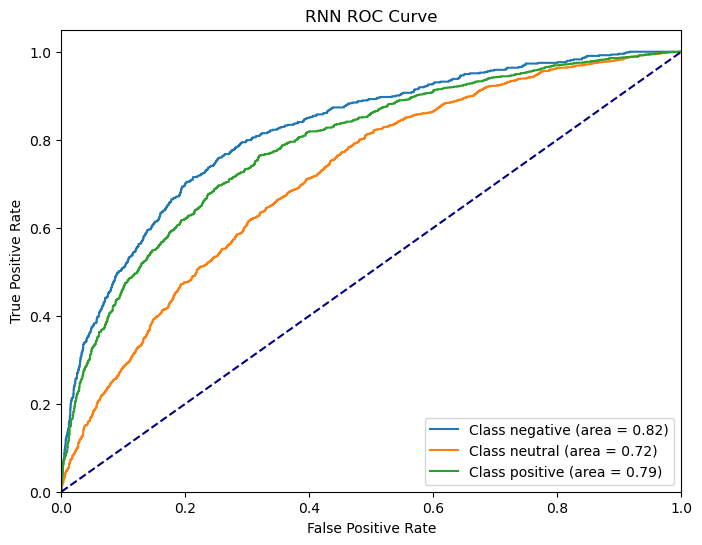

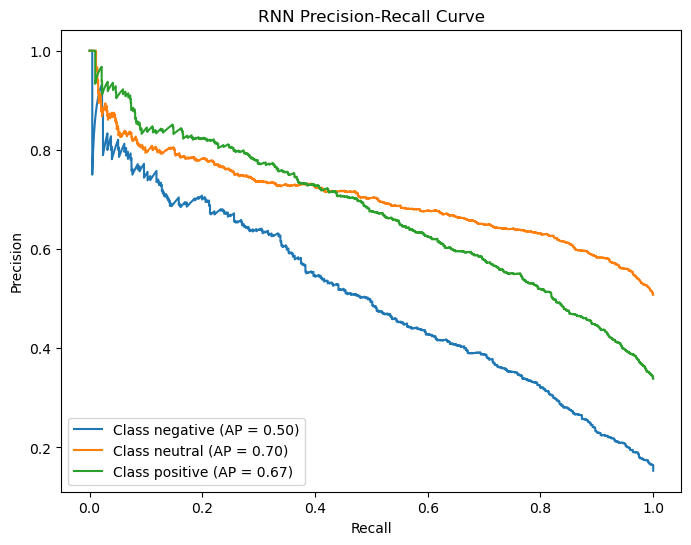

In [129]:
def evaluate_model(model, X_test_pad, y_test, model_name):
    y_pred = model.predict(X_test_pad)
    y_pred_classes = np.argmax(y_pred, axis=1)
    print(f"{model_name} Classification Report:\n", classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))
    plot_roc_curve(y_test, y_pred, model_name)
    plot_precision_recall_curve(y_test, y_pred, model_name)

evaluate_model(best_rnn_model, X_test_pad, y_test, 'RNN')

129/129 ━━━━━━━━━━━━━━━━━━━━ 13s 97ms/step
LSTM Classification Report:
               precision    recall  f1-score   support

    negative       0.70      0.32      0.44       632
     neutral       0.64      0.81      0.72      2097
    positive       0.66      0.56      0.60      1398

    accuracy                           0.65      4127
   macro avg       0.67      0.56      0.59      4127
weighted avg       0.66      0.65      0.64      4127



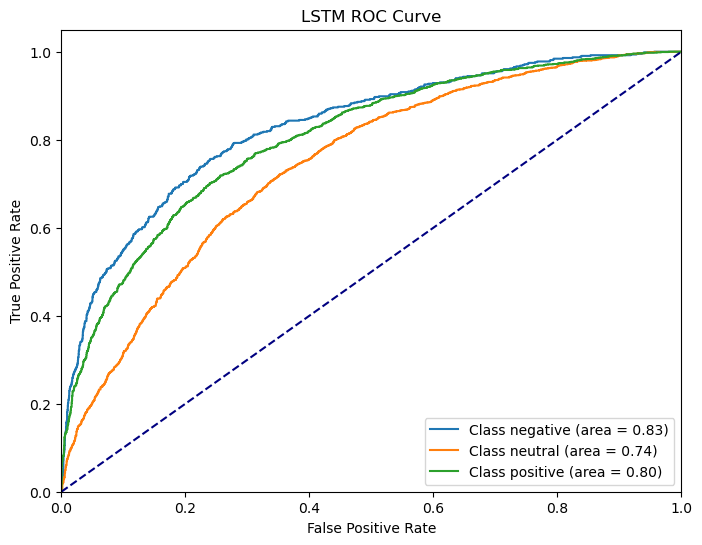

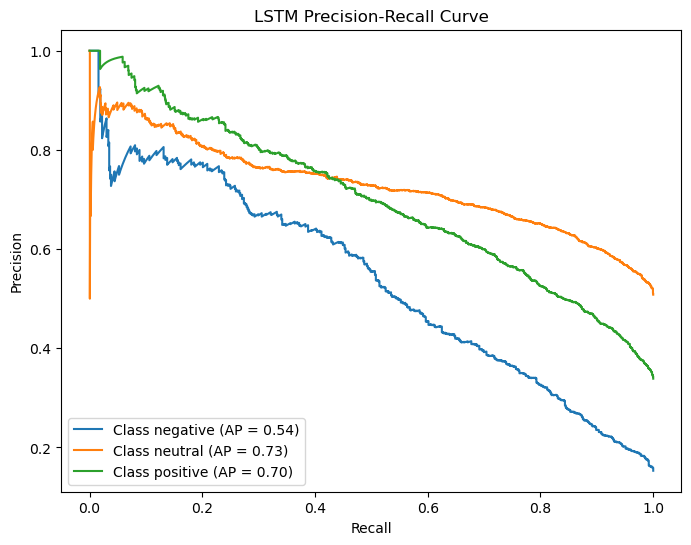

In [133]:
evaluate_model(best_lstm_model, X_test_pad, y_test, 'LSTM')

129/129 ━━━━━━━━━━━━━━━━━━━━ 39s 299ms/step
BiLSTM Classification Report:
               precision    recall  f1-score   support

    negative       0.61      0.40      0.48       632
     neutral       0.65      0.83      0.73      2097
    positive       0.72      0.53      0.61      1398

    accuracy                           0.66      4127
   macro avg       0.66      0.59      0.61      4127
weighted avg       0.67      0.66      0.65      4127



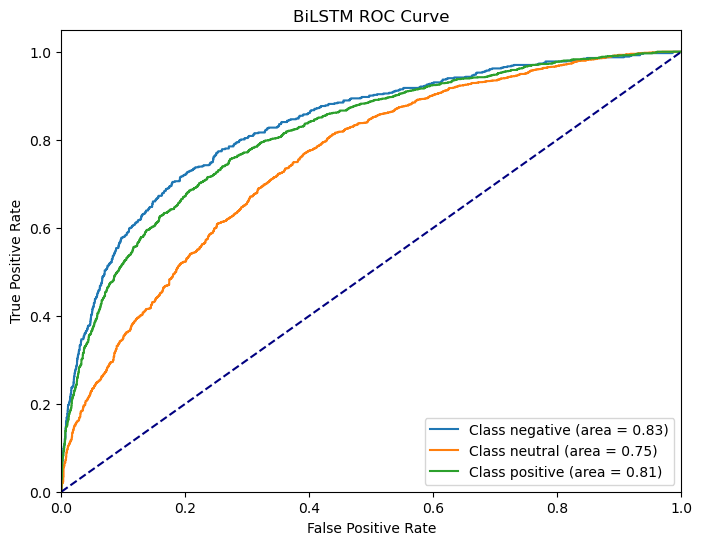

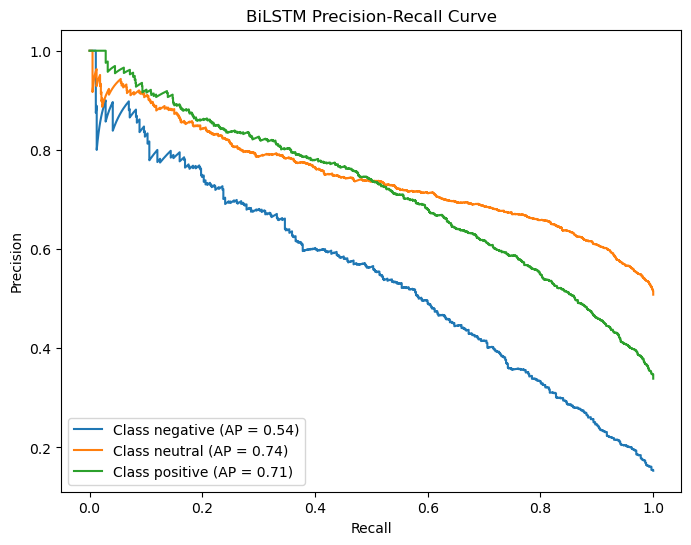

In [131]:
evaluate_model(best_bilstm_model, X_test_pad, y_test, 'BiLSTM')